In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 95% 295M/309M [00:02<00:00, 104MB/s]
100% 309M/309M [00:02<00:00, 113MB/s]


In [ ]:
!unzip /content/human-emotions-datasethes.zip -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, RandomRotation, RandomFlip, RandomContrast, Resizing, Rescaling, MaxPooling2D, GlobalAveragePooling2D, Add, Activation, Input, Embedding, LayerNormalization, MultiHeadAttention, Permute
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_probability as tfp
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6 ,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE":2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES":3
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

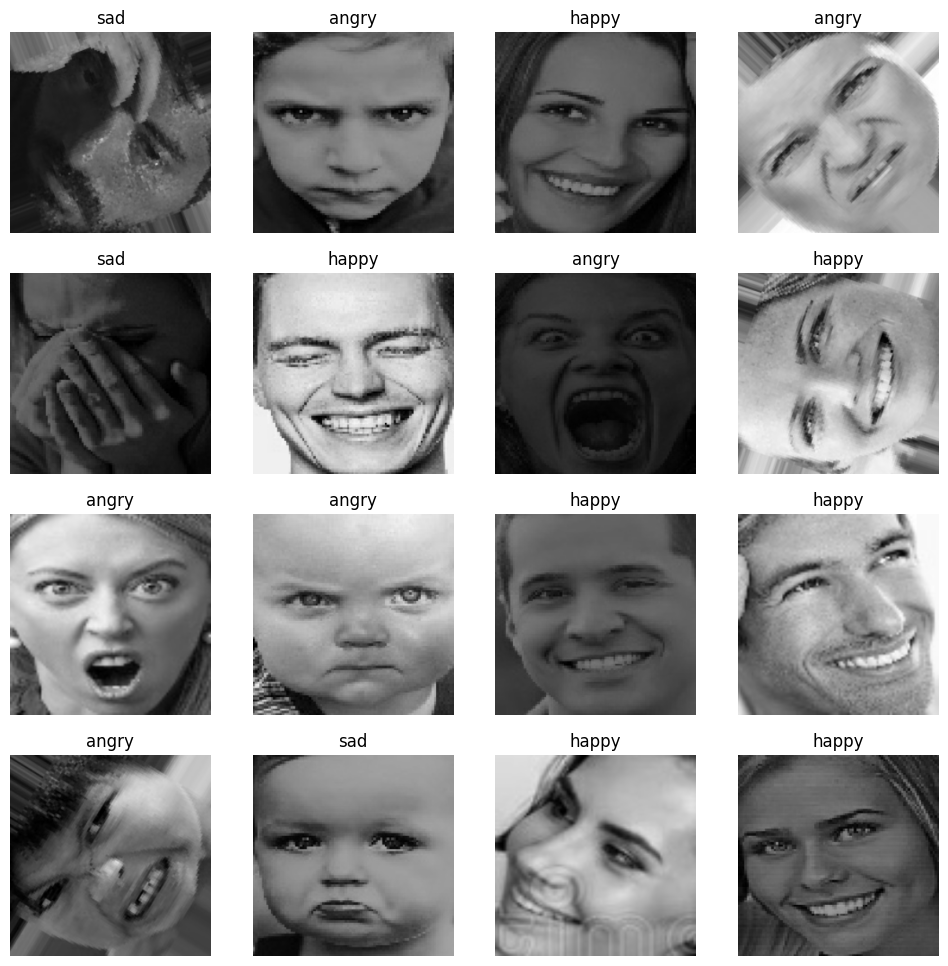

In [ ]:
plt.figure(figsize=(12,12))

for image, label in train_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(label[i], axis=0).numpy()])
    plt.axis("off")

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

def augment_layer(image, label):
  return augment_layers(image, training=True), label

In [ ]:
def box(lamda):
  r_x =  tf.cast(tfp.distributions.Uniform(0,CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype= tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0,CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype= tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype=tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype=tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = y_b_r - r_y
  if (r_w == 0):
    r_w = 1
  r_h = x_b_r - r_x
  if (r_h == 0):
    r_h = 1

  return r_x, r_y, r_w, r_h

In [ ]:
def cut_mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_2= tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"])
  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = 1 - (r_h*r_w)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"])
  label = lamda*tf.cast(label_1, dtype=tf.float64) + (1-lamda)*tf.cast(label_2, dtype=tf.float64)

  return image, label

In [ ]:
train_dataset_1  = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(augment_layer)
train_dataset_2  = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(augment_layer)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))


In [ ]:
training_dataset = (train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))
# training_dataset = (mixed_dataset.map(cut_mixup, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))
validation_dataset = (val_dataset.prefetch(tf.data.AUTOTUNE))

# training_dataset = train_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
# validation_dataset = (val_dataset)

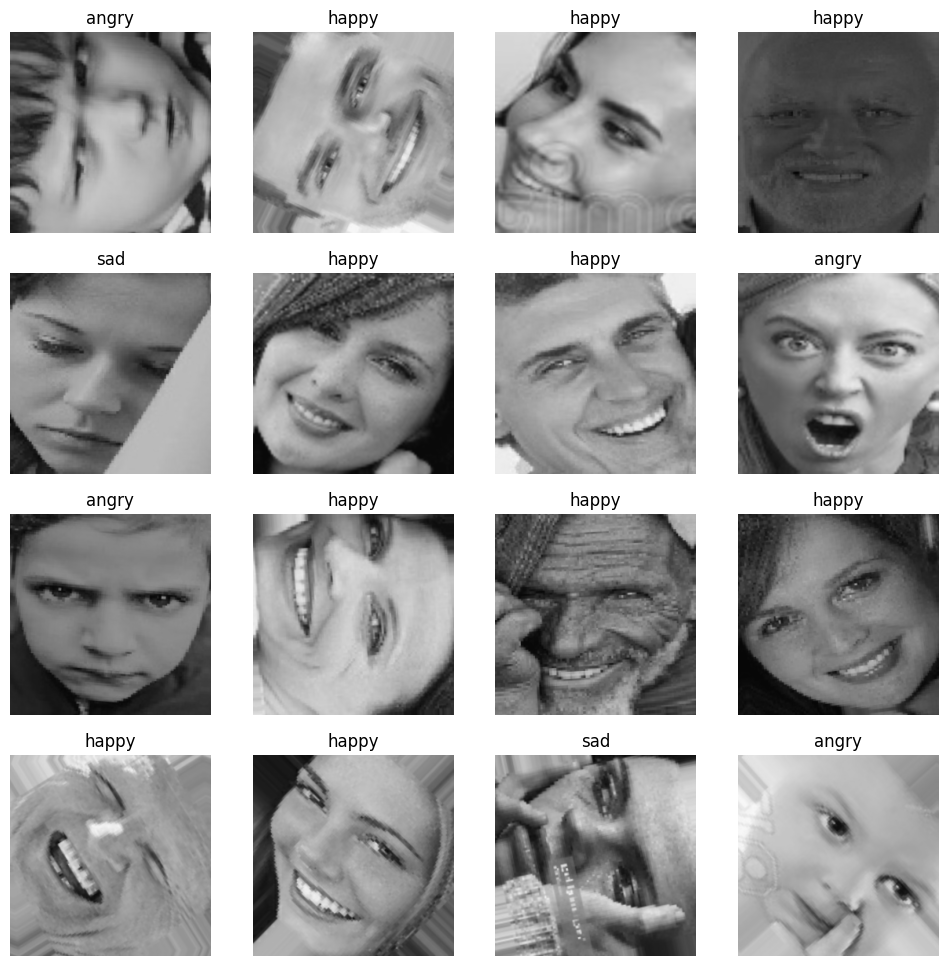

In [ ]:
plt.figure(figsize=(12,12))

for image, label in training_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(label[i], axis=0).numpy()])
    plt.axis("off")

In [ ]:
training_dataset = training_dataset.unbatch()
validation_dataset = validation_dataset.unbatch()

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
# def encode_image(image, label):
#   image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
#   image = tf.io.encode_jpeg(image)
#   return image,label

def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,int(tf.argmax(label))

In [ ]:
encoded_dataset = (
  training_dataset
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(filenames=[PATH.format(p) for p in range(NUM_SHARDS)])

In [ ]:
def parse_tfrecords(example):

  feature_description = {
      'images': tf.io.FixedLenFeature([], tf.string),
      'labels': tf.io.FixedLenFeature([], tf.int64)
  }

  example = tf.io.parse_single_example(example, feature_description)
  example['images'] = tf.io.decode_jpeg(example['images'], channels=3)

  return example['images'], example['labels']

In [ ]:
parsed_dataset = recons_dataset.map(parse_tfrecords).batch(CONFIGURATION["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE)

In [ ]:
parsed_dataset.take(1)

In [ ]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescale_layer,

    Conv2D(filters = CONFIGURATION["N_FILTERS"], kernel_size = CONFIGURATION["KERNEL_SIZE"],
           strides = CONFIGURATION["N_STRIDES"], padding = 'valid', activation = 'relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides =  CONFIGURATION["N_STRIDES"] * 2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]* 2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"],
           strides = CONFIGURATION["N_STRIDES"], padding = 'valid', activation = 'relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION["POOL_SIZE"], strides =  CONFIGURATION["N_STRIDES"] * 2),

    Flatten(),
    Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(CONFIGURATION["DROPOUT_RATE"]),
    Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu', kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax', name="output")
])

lenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 256, 3]), training = True) # for building resnet model -> For seeing summary
resnet_34.summary()

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
)

In [ ]:
backbone.trainable = False
# backbone.trainable = True

In [ ]:
model = tf.keras.Sequential([
    Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu'),
    Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
])

model.summary()

In [ ]:
input = Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

x = backbone(input, training = False)

x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu')(x)
x = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')(x)

model = Model(input, x)
model.summary()

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,
    )

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [ ]:
n_sample_0 = 1525 # angary
n_sample_1 = 3019 # happy
n_sample_2 = 2255 # sad

In [ ]:
# 6799 -> total inputs
class_weights = {0:6799/n_sample_0, 1:6799/n_sample_1, 2:6799/n_sample_2}

In [ ]:
lenet_model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]), #use smaller learning rate during fie tuning of pre train model
                    loss=loss_function,
                    metrics=metrics)

In [ ]:
history = lenet_model.fit(training_dataset, validation_data=validation_dataset, epochs=CONFIGURATION["N_EPOCHS"], verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [ ]:
lenet_model.evaluate(validation_dataset)

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

CLASS_NAMES[(tf.argmax(lenet_model(im), axis=-1)).numpy()[0]]

In [ ]:
plt.figure(figsize=(12,12))

for image, label in val_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255.)
    plt.title("Predicted Label:" + CLASS_NAMES[(tf.argmax(lenet_model(im), axis=-1)).numpy()[0]] + "\n" + "True Label:" + CLASS_NAMES[tf.argmax(label[i], axis=0).numpy()])
    plt.axis("off")

In [ ]:
labels = []
predicted = []

for image, label in val_dataset:
  predicted.append(lenet_model(image))
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()]))

In [ ]:
label = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])
pred  = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])

In [ ]:
cm = confusion_matrix(label, pred)
print(cm)

plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3),
)

In [ ]:
vgg_backbone.summary()

In [ ]:
def is_conv(layer_name):
  if "conv" in layer_name:
    return True
  return False

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(inputs = vgg_backbone.input, outputs=feature_maps)

feature_map_model.summary()

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/100610.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

f_maps = feature_map_model.predict(im)

In [ ]:
len(f_maps)

In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize=(256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels))

  axs = plt.subplot(len(f_maps), 1, i+1)
  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][...,j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)


In [ ]:
preds = model.predict(im)

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
last_conv_layer_model.summary()

In [ ]:
for layer in pretrained_model.layers:
  print(layer.name)

In [ ]:
classifier_layer_names = [
 "global_average_pooling2d_5",
 "dense_15",
 "dense_16",
 "dense_17"
]

In [ ]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(im)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
grads.shape

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
pooled_grads.shape

In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
last_conv_layer_output.shape

In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+im[0,:,:,0]/255)

In [ ]:
input = Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

y_1 = model(input)
y_2 = pretrained_model(input)

output = 0.5*y_1 + 0.5*y_2

ensemble_model = Model(inputs=input, outputs=output)

In [ ]:
ensemble_model.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
                    loss=loss_function,
                    metrics=metrics)

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.expand_dims(test_image, axis=0)

patches = tf.image.extract_patches(
    images=im,
    sizes=[1, 16, 16, 1],
    strides=[1, 16, 16, 1],
    rates=[1, 1, 1, 1],
    padding='VALID',
)

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0],256, 768))
print(patches.shape)

In [ ]:
plt.figure(figsize=(8,8))

for i in range(patches.shape[1]):
    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16, 16, 3)))
    plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
      images=x,
      sizes=[1, 16, 16, 1],
      strides=[1, 16, 16, 1],
      rates=[1, 1, 1, 1],
      padding='VALID',
      )
    patches = tf.reshape(patches, (tf.shape(patches)[0] ,256, patches.shape[-1]))

    embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta=1)
    output =  self.linear_projection(patches) + self.positional_embedding(embedding_input,)

    return output

In [ ]:
patch_enc = PatchEncoder(256, 768)
patch_enc(tf.zeros([2, 256, 256, 3]))

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multihead_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 =  self.multihead_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)

    output = Add()([output, x_1])

    return output

In [ ]:
trans_enc = TransformerEncoder(8, 768)
trans_enc(tf.zeros([1, 256, 768]))

In [ ]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNIT):
    super(ViT, self).__init__(name = 'vision_transformer')

    self.N_LAYERS = N_LAYERS

    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.transformer_encoder = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]

    self.dense_1 = Dense(N_DENSE_UNIT, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNIT, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")

  def call(self, input, training = True):
    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.transformer_encoder[i](x)

    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)


In [ ]:
vit = ViT(8, 768, 256, 4, 1024)
vit(tf.zeros([32, 256, 256, 3]))

In [ ]:
vit.summary()

In [ ]:
vit.compile(optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
                    loss=loss_function,
                    metrics=metrics)

In [ ]:
vit.fit(training_dataset, validation_data=validation_dataset, epochs=2, verbose=1)

In [ ]:
!pip install transformers

In [ ]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig(hidden_size=144)

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
configuration

In [ ]:
resize_rescale_hf = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1./255),
    Permute((3,1,2))
])

In [ ]:
from transformers import AutoImageProcessor, TFViTModel

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
inputs = Input(shape=(256, 256, 3))

x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:, 0, :] # we are only intrested in class embbeding output

output = Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

hf_model = Model(inputs=inputs, outputs=output)

In [ ]:
lenet_model.export("LenetModel")

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime # run onnx model in cpu runtime
!pip install onnxruntime-gpu # run onnx model in gpu runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.1/223.1 MB 6.4 MB/s eta 0:00:00


In [ ]:
!python -m tf2onnx.convert --saved-model LenetModel/ --output vit_model.onnx

2024-08-19 05:09:42.594376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 05:09:42.620305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 05:09:42.626851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 05:09:44.271496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
I

In [ ]:
lenet_model.save("LenetModel.h5")

In [ ]:
import tf2onnx
import onnxruntime as rt

lenet_model.output_names=['output']

spec = (tf.TensorSpec(
        (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
        tf.float32, name="input"),)

output_path = "vit_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(lenet_model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
output_names

['output']

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype=tf.float32)
im = np.expand_dims(im, axis=0)


In [ ]:
import time

# providers = ["CPUExecutionProvider"] # for cpu runtime
# providers = ["CUDAExecutionProvider"] # For gpu runtime
providers = ["CUDAExecutionProvider", "CPUExecutionProvider"]

m = rt.InferenceSession(output_path, providers=providers)

t1 = time.time()
for _ in range(10):
  onnx_pred = m.run(output_names, {"input": im})
print(time.time() - t1)

0.1527109146118164


In [ ]:
onnx_pred

[array([[0.3916028 , 0.2766148 , 0.33178234]], dtype=float32)]

In [ ]:
t1 = time.time()
for _ in range(10):
  lenet_model(im)
print(time.time() - t1)



2.1151013374328613


In [ ]:
rt.get_device()

'GPU'

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = "/content/vit_keras.onnx"
model_quant = "/content/vit_keras_quant.onnx"

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)

In [ ]:
providers = ["CUDAExecutionProvider", "CPUExecutionProvider"]

m = rt.InferenceSession(model_quant, providers=providers)

t1 = time.time()
for _ in range(10):
  onnx_pred = m.run(output_names, {"input": im})
print(time.time() - t1)

In [ ]:
def accuracy(model):
  total, acc = 0
  for image, label in val_dataset.take(100):
    onnx_pred = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_pred, axis=-1)) == int(np.argmax(label, axis=-1)[0])):
      acc += 1
    total += 1

  return acc/total

In [ ]:
providers = ["CPUExecutionProvider"]
m = rt.InferenceSession("content/vit_keras.onnx", providers=providers)
qm = rt.InferenceSession("/content/vit_keras_quant.onnx", providers=providers)

print(accuracy(m))
print(accuracy(qm))

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
lenet_model_q = tf.keras.Sequential([
    InputLayer(input_shape=(256, 256, 3)),
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"], padding='valid', activation='relu',
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    Conv2D(filters=CONFIGURATION["N_FILTERS"] * 2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"], padding='valid', activation='relu',
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),
    Flatten(),
    Dense(CONFIGURATION["N_DENSE_1"], activation='relu',
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    Dropout(CONFIGURATION["DROPOUT_RATE"]),
    Dense(CONFIGURATION["N_DENSE_2"], activation='relu',
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax', name="output")
])

lenet_model_q.build(input_shape=(None, 256, 256, 3))
lenet_model_q.summary()

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_model(lenet_model_q)

In [ ]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [ ]:
quant_aware_eff = tf.keras.models.clone_model(
    lenet_model_q, clone_function=apply_quantization_to_conv
)

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

In [ ]:
def representative_data_gen():
  for input_value, j in training_dataset.take(20):
    yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(lenet_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen

In [ ]:
tflite_model = converter.convert()

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/content/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"lenet_model.tflite"
tflite_model_file.write_bytes(tflite_model)

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

In [ ]:
import tflite_runtime.interpreter as tflite

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109046.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

test_image = np.expand_dims(test_image, axis=0)


In [ ]:
interpreter = tflite.Interpreter(model_path="/content/tflite_models/lenet_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
# test_image = im.numpy().astype(input_details["dtype"])

interpreter.set_tensor(input_details["index"], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]


In [ ]:
output

In [ ]:
def accuracy(model_path):
  total, correct = 0,0
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  for im, label in validation_dataset:

    test_image = im.numpy().astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    if(int(np.argmax(output)) == int(np.argmax(label, axis = -1)[0])):
      correct += 1

    total += 1
  return correct/total